# LSTMs

The content for this course (including many of the images) comes from the excellent [colah's blog](https://colah.github.io) - specifically the post [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and from [deeplearning.ai Sequence Course](https://www.coursera.org/learn/nlp-sequence-models)

## Sigmoid versus Tanh 

Tanh
- [-1, 1]
- naturally suited to create output distributions similar to a normal distribution
- are good at capturing statistical features like "this one is average", "this one is in the 10th percentile"

Sigmoid
- [0, 1]
- naturally suited for probabilities or relative amounts - a relative amount to signify how strongly the incoming values should be considered
- they don't add up to 100%. that's what softmax is for

##  Challenges with recurrent neural networks

Two historical challenges
- how to train (vanishing & exploding gradients)
- how to remember long term (the long term dependency problem)

Why does the RNN architiecture cause these two challenges?

LSTMs specifically address both of these problems.  They were introduced in 1997 (see [Hochreiter & Schmidhuber (1997) Long Short-Term Memory](http://www.bioinf.jku.at/publications/older/2604.pdf)), and work well on a wide range of problems.

## The LSTM

The **Long Short Term Memory (LSTM)** network is composed of memory cells.  These cells are composed of three gates
- forget gate = what to discard from the state (reset)
- input gate = update the state (write)
- output gate = what to output (read)

The input & forget gate update the internal state.  The input gate protect the cell from irrelevant inputs, the output gate protects other units.  

The rest of the neural network communicates with the cells via these gates.  The gates ensure a stable error signal (known as a *constant error carrousel*).

These gates not only help with keeping gradients consistent, they also help with longer term memory.

## Limitations of LSTMs

They are not a solution to everything!  

Time series problems where the relevant infomation is within a small time window - or problems that are well solved by traditional autoregression models (ARMIA etc)

## Future of LSTMs

**Attention (2013)** - let every step of an RNN pick information to look at from some larger collection of information

## Recurrent recap

Infomation is fed to the next timestep

<img src="assets/RNN.png" alt="" width="800"/>

## LSTM architecture

In the LSTM we have more complexity in the cell

![](assets/LSTM.png)
![](assets/lstm.png)


## Three gates

### 1 - Forget gate

<img src="assets/forget.png" alt="" width="300"/>

How much of the cell state to forget based on the next observation in the sequence ($x$) and hidden state ($h$)


Output of sigmoid (between 0 and 1) operates on the cell state
- 0 = forget everything
- 1 = remember everything

$$ f_{t} = sigmoid(W_{f} \cdot [h_{t-1}, x_t] + B_{f}) $$

Imagine we are reading words in a piece of text, and want use an LSTM to keep track of grammatical structures, such as whether the subject is singular or plural. If the subject changes from a singular word to a plural word, we need to find a way to get rid of our previously stored memory value of the singular/plural state. In an LSTM, the forget gate let's us do this.

### 2 - Input gate or Update gate

<img src="assets/input.png" alt="" width="300"/>

Once we forget that the subject being discussed is singular, we need to find a way to update it to reflect that the new subject is now plural. 

There are three steps here:

1. Decide what to update

How to update the cell state based on the next observation in the sequence ($x$) and hidden state ($h$). 

$$ i_{t} = sigmoid(W_{i} \cdot [h_{t-1}, x_t] + B_{i})) $$

Similar to the forget gate, the value is again a vector of values between 0 and 1. 

2. Candidate vector:

To update the new subject we need to create a new vector of numbers that we can add to our previous cell state. The equation we use is:

$$ \overset{\sim}{C}_{t} = tanh(W_{C} \cdot [h_{t-1}, x_t] + B_{C})) $$


3. Update the values:
The new cell state is given by element-wise multiplication of the update gate and candidate.

We can now put together the results of our forget and input gates:

$$ C_{t} = f_{t} * {C}_{t-1} + i_{t} * \overset{\sim}{C}_{t} $$

### 3 - Output gate

<img src="assets/output.png" alt="" width="300"/>

Which parts of the cell state to output based on the next observation in the sequence ($x$) and hidden state ($h$)

What to output from the cell state:

$$ o_{t} = sigmoid(W_{o}[h_{t-1},x_{t}] + b_{o}])$$

What the output should be:

$$ h_{t} = o_{t} * tanh(C_{t}) $$

## Gated Recurrent Units (GRUs)

Simpler than LSTMs & popular

Forget & input gates combined into an update gate

Cell state & hidden state merged together

[Cho, et al. (2014) Learning Phrase Representations using RNN Encoder–Decoder
for Statistical Machine Translation](https://arxiv.org/pdf/1406.1078v3.pdf)

![](assets/gru.png)

See [Greff et. al (2017) LSTM: A Search Space Odyssey](https://arxiv.org/pdf/1503.04069.pdf) for a comparison of different LSTM variants.

## Practical

Predict a damped sin wave using an LSTM:

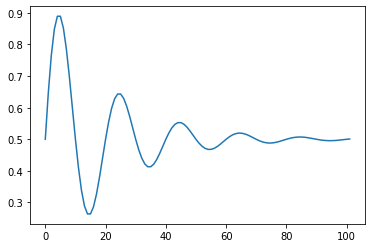

In [2]:
from math import sin, pi, exp
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

def generate_sequence(length, period, decay):
    '''
    Generate damped sine wave in [0,1].
    When the wave is damped, each successive peak decreases as time goes on.
    that is, the amplitude approaches zero as time increases.
    
    Parameters:
    --------
    length: int. How many time-steps to generate for the wave.
    period: int. The time it takes for a single cycle.
    decay: float. constant of decay
    '''
    
    return np.array([0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) for i in range(length)])

f, a = plt.subplots()
_ = a.plot(generate_sequence(102, 20, 0.05))

### Problem statement
Given sine waves with different wave length, phases and lengths, predict the rest of wave. 
It is a **many-to-one** problem because the model will receive the sequence and then make a single prediction at once. This prediction is for n time steps.

<img src="assets/dumped_sine_wave_problem.png" alt="" width="250"/>


### Steps
1. Generate dataset of input-output samples to train the model
+ Define and train a Staked LSTM model: that is, a LSTM layer as input, another hidden LSTM layer and the output layer
    + each LSTM layer has 20 blocks, or neurons
    + output layer is Dense to produce the output sequence, with a linear activation function (default when no function is specified)
    + use MSE as loss function    
+ Predict
+ Evaluate predictions

About the input and output
+ the input is a vector with 50 time steps
+ the output is be a vector of 5 values, that is, 5 time steps

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers

np.random.seed(0) 

In [8]:
def generate_dataset(seq_len, n, output_size):
    '''
    Generate dataset of damped sine waves with random periods and decays.
    Dimension of dataset = (n, seq_len, 1)

    
    Parameters:
    --------
    seq_len: int.  How many time-steps to generate for each wave.
    n: int. Number of samples in the dataset.
    output_size: int. Length of output sequence.
    
    Returns:
    --------
    x: array. dimension = (n, seq_len, 1)
    y: array. dimension = (n, output_size)
    
    '''
    x, y = list(), list()
    
    ### code here
    for i in range(n):
        p = np.random.randint(10,20)
        d = np.random.uniform(0.01, 0.1)
        wave = generate_sequence(seq_len + output_size, p, d)
        x.append(wave[:-output_size])
        y.append(wave[-output_size:])
        
    x = np.array(x).reshape(n, seq_len, 1)
    y = np.array(y).reshape(n, output_size)
    
    return x, y
 


length = 50
output = 5
x_train, y_train = generate_dataset(length, 10000, output)

print(x_train.shape)
y_train.shape

(10000, 50, 1)


(10000, 5)

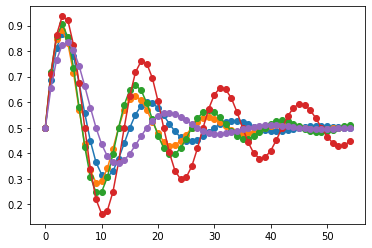

In [9]:
import matplotlib.pyplot as plt


for i in range(5):
    plt.plot([x for x in x_train[i,:,0]] + [x for x in y_train[i]], '-o')
    
# 5 damped sine wave sequenes with each 50 time steps.
# additional 5 steps are generated at the end of the sequence
# which will be held as test data

In [ ]:
from tensorflow.keras.layers import LSTM, Dense


### Training
The network is trained using the backpropagation algorithm and optimized according to the optimization algorithm and loss function specified when compiling the model.

The backpropagation algorithm requires that the network be trained for a specified number of epochs or exposures to the training dataset.

Each epoch can be partitioned into groups of input-output pattern pairs called batches. This defines the number of patterns that the network is exposed to before the weights are updated within an epoch. It is also an efficiency optimization, ensuring that not too many input patterns are loaded into memory at a time.

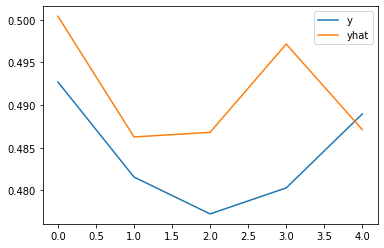

In [15]:
# evaluate on one wave
new_x, new_y = generate_dataset(length, 1, output)
new_y_hat = model.predict(new_x)


plt.plot(new_y[0], label='y');
plt.plot(new_y_hat[0], label='yhat');
plt.legend()

The choice of activation function is most important for the output layer as it will define the format that predictions will take.


For example, below are some common predictive modeling problem types and the structure and standard activation function that you can use in the output layer:


+ Regression: Linear activation function, or ‘linear’, and the number of neurons matching the number of outputs.
+ Binary Classification (2 class): Logistic activation function, or ‘sigmoid’, and one neuron the output layer.
+ Multiclass Classification (>2 class): Softmax activation function, or ‘softmax’, and one output neuron per class value, assuming a one-hot encoded output pattern.